## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## Perform feature extraction on a labeled training set of images : Histogram of Oriented Gradients (HOG) and Histogram of Colors

In [1]:
#all defines
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
%matplotlib inline



In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute color histogram features  
def channel_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the one channels separately
    channel_hist = np.histogram(img, bins=nbins, range=bins_range)
    #print(channel_hist)
    # Return the individual histograms, bin_centers and feature vector
    return channel_hist[0]


# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
# Convert image to new color space (if specified)
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size)
    # Return the feature vector
    return features

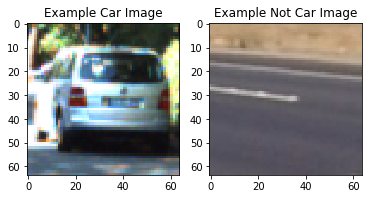

In [26]:
# Read in our vehicles and non-vehicles
images = glob.glob('dataset/*/*/*.png')
cars = []
notcars = []

# make a list of cars and non-car images location
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image_car = mpimg.imread(cars[ind])

# Generate a random index to look at a car image
ind = np.random.randint(0, len(notcars))
# Read in the image
image_notcar = mpimg.imread(notcars[ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image_car)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(image_notcar)
plt.title('Example Not Car Image')
plt.savefig('result/dataset_example.jpg')

/Users/hassan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


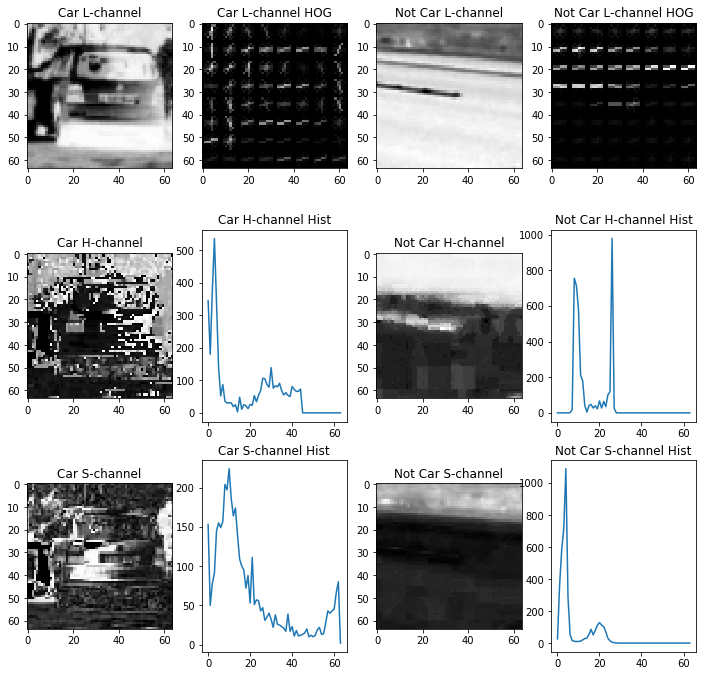

In [30]:
# Feature Parameters
spatial_size=(64, 64)
orient = 9; pix_per_cell = 8; cell_per_block = 2
hist_bins=64; hist_range=(0, 256)
        
#apply appropriate scaling, as training samples are png so scale them up to 255
image_car = np.uint8(image_car*255)

 # Convert to HLS color space, resize to 32x32 and separate the channels
hls_resize32 = bin_spatial(image_car, color_space='HLS', size=spatial_size)
#hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = hls_resize32[:,:,0]
l_channel = hls_resize32[:,:,1]
s_channel = hls_resize32[:,:,2]

# Call our function with vis=True to see an image output
hog_features,hog_image = get_hog_features(l_channel, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
hog_features = hog_features.ravel()

# histogram of S plane
hist_features_S = channel_hist(s_channel, nbins=hist_bins, bins_range=hist_range)
#hist_features_S = hist_features_S[10:]

# histogram of H plane
hist_features_H = channel_hist(h_channel, nbins=hist_bins, bins_range=hist_range)
#hist_features_H = hist_features_H[:-8]

# Plot the examples
fig = plt.figure(figsize=(12,12))
plt.subplot(341)
plt.imshow(l_channel, cmap='gray')
plt.title('Car L-channel')
plt.subplot(342)
plt.imshow(hog_image, cmap='gray')
plt.title('Car L-channel HOG')
plt.subplot(345)
plt.imshow(h_channel, cmap='gray')
plt.title('Car H-channel')
plt.subplot(346)
plt.plot(hist_features_H)
plt.title('Car H-channel Hist')
plt.subplot(349)
plt.imshow(s_channel, cmap='gray')
plt.title('Car S-channel')
plt.subplot(3,4,10)
plt.plot(hist_features_S)
plt.title('Car S-channel Hist')

#apply appropriate scaling, as training samples are png so scale them up to 255
image_notcar = np.uint8(image_notcar*255)

 # Convert to HLS color space, resize to 32x32 and separate the channels
hls_resize32 = bin_spatial(image_notcar, color_space='HLS', size=spatial_size)
#hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = hls_resize32[:,:,0]
l_channel = hls_resize32[:,:,1]
s_channel = hls_resize32[:,:,2]

# Call our function with vis=True to see an image output
hog_features,hog_image = get_hog_features(l_channel, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
hog_features = hog_features.ravel()

# histogram of S plane
hist_features_S = channel_hist(s_channel, nbins=hist_bins, bins_range=hist_range)
#hist_features_S = hist_features_S[10:]

# histogram of H plane
hist_features_H = channel_hist(h_channel, nbins=hist_bins, bins_range=hist_range)
#hist_features_H = hist_features_H[:-8]


# Plot the examples
plt.subplot(3,4,3)
plt.imshow(l_channel, cmap='gray')
plt.title('Not Car L-channel')
plt.subplot(3,4,4)
plt.imshow(hog_image, cmap='gray')
plt.title('Not Car L-channel HOG')
plt.subplot(3,4,7)
plt.imshow(h_channel, cmap='gray')
plt.title('Not Car H-channel')
plt.subplot(3,4,8)
plt.plot(hist_features_H)
plt.title('Not Car H-channel Hist')
plt.subplot(3,4,11)
plt.imshow(s_channel, cmap='gray')
plt.title('Not Car S-channel')
plt.subplot(3,4,12)
plt.plot(hist_features_S)
plt.title('Not Car S-channel Hist')
plt.savefig('result/feature_example.jpg')

## Extract the features on complete dataset and normalize the features

/Users/hassan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(8792, 1874)
(8968, 1874)


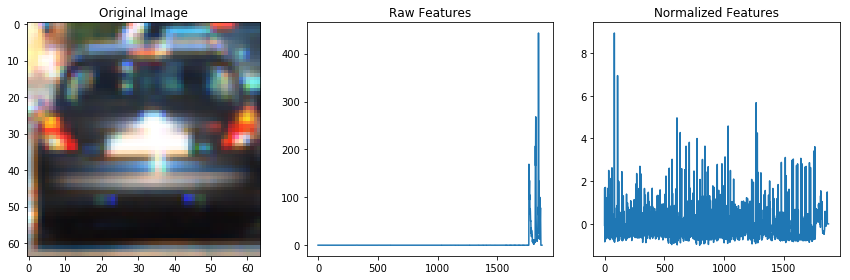

In [48]:
###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='HLS', spatial_size=(32, 32),
                     orient = 9, pix_per_cell = 8, cell_per_block = 2,
                     hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    count = 0
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        #print(count)
        count = count+1
        image = mpimg.imread(file)
        #apply appropriate scaling, as training samples are png so scale them up to 255
        image = np.uint8(image*255)
        # Convert to HLS color space, resize to 32x32 and separate the channels
        #yuv_resize32 = bin_spatial(image, color_space='YUV', size=spatial_size)
        #y_channel = yuv_resize32[:,:,0]
        
        
        
         # Convert to HLS color space, resize to 32x32 and separate the channels
        hls_resize32 = bin_spatial(image, color_space='HLS', size=spatial_size)
        #hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
        h_channel = hls_resize32[:,:,0]
        l_channel = hls_resize32[:,:,1]
        s_channel = hls_resize32[:,:,2]
        
        # Call our function with vis=True to see an image output
        hog_features = get_hog_features(l_channel, orient, 
                                pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=False)
        hog_features = hog_features.ravel()
        
        # histogram of S plane
        hist_features_S = channel_hist(s_channel, nbins=hist_bins, bins_range=hist_range)
        hist_features_S = hist_features_S[10:]
        
        # histogram of H plane
        hist_features_H = channel_hist(h_channel, nbins=hist_bins, bins_range=hist_range)
        hist_features_H = hist_features_H[:-8]
        #print(hist_features_H)

        
        #concatenate the features to one feature vector
        feature_vector = np.concatenate((hog_features, hist_features_S, hist_features_H))
        #feature_vector = hog_features

        # Append the new feature vector to the features list
        features.append(feature_vector)
    # Return list of feature vectors
    return features


car_features = extract_features(cars, cspace='HLS', spatial_size=(64, 64),
                        orient = 9, pix_per_cell = 8, cell_per_block = 2,
                        hist_bins=64, hist_range=(0, 256))
print(np.shape(car_features))
notcar_features = extract_features(notcars, cspace='HLS', spatial_size=(64, 64),
                        orient = 9, pix_per_cell = 8, cell_per_block = 2,
                        hist_bins=64, hist_range=(0, 256))
print(np.shape(notcar_features))


if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.savefig('result/Normalization_example.jpg')
else: 
    print('Your function only returns empty feature vectors...')

## Classification Preparation : Randomize and defining training, testing set

In [33]:
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
#from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn import svm
from sklearn.model_selection import GridSearchCV

import time

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

/Users/hassan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Train and Test the SVM classifier 

In [34]:
GridSearch = False
# turn off the grid search if best parameters already identified on validation set

if GridSearch:

    #clf = SVC(kernel="linear")
    #parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.1, 1, 10]}
    #parameters = {'kernel':['linear', 'rbf'], 'C':[2, 4, 6, 8], 'gamma':[.002,.004, .006, .008]}
    parameters = {'kernel':['rbf'], 'C':[2, 4, 6, 8]}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters)

    #### now your job is to fit the classifier
    #### using the training features/labels, and to
    #### make a set of predictions on the test data
    # Check the training time for the SVC
    t=time.time()
    clf.fit(X_train, y_train) 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')


    #### store your predictions in a list named pred
    pred = clf.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print('Test Accuracy of SVC = ', round(acc, 4))
    print('Best Results at following parameter set : ',clf.best_params_)
    

In [35]:
# just to confirm with the best parameters
#clf = svm.SVC(kernel='rbf',C=4,gamma= .004)
clf = svm.SVC(kernel='rbf',C=4)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train) 
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


#### store your predictions in a list named pred
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print('Test Accuracy of SVC = ', round(acc, 4))

80.45 Seconds to train SVC...
Test Accuracy of SVC =  0.9949


## Apply a windowing on test image

/Users/hassan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


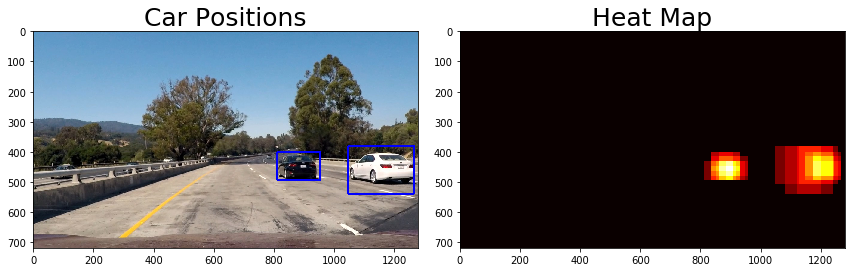

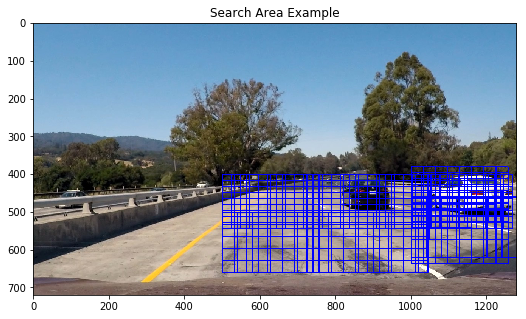

In [60]:
from scipy.ndimage.measurements import label


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf, 
              orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
              cells_per_step_x, cells_per_step_y,record_window=False):
    crop_img = img[crop_y:crop_y+crop_h,crop_x:crop_x+crop_w]


    #cells_per_step_x = 2  # Instead of overlap, define how many cells to step
    #cells_per_step_y = 2  # Instead of overlap, define how many cells to step

    #print(crop_img.shape)

    # step 1 : 
    crop_img_HLS = cv2.cvtColor(crop_img, cv2.COLOR_RGB2HLS)
    #crop_img_YUV = cv2.cvtColor(crop_img, cv2.COLOR_RGB2YUV)

    if scale_x != 1 or scale_y != 1:
        imshape = crop_img_HLS.shape
        crop_img_HLS_resize = cv2.resize(crop_img_HLS, (np.int(imshape[1]/scale_x), np.int(imshape[0]/scale_y)))
        #crop_img_YUV_resize = cv2.resize(crop_img_YUV, (np.int(imshape[1]/scale_x), np.int(imshape[0]/scale_y)))
    else:
        crop_img_HLS_resize = np.copy(crop_img_HLS)
        #crop_img_YUV_resize = np.copy(crop_img_YUV)

    #y_channel = crop_img_YUV_resize[:,:,0]
    
    h_channel = crop_img_HLS_resize[:,:,0]
    l_channel = crop_img_HLS_resize[:,:,1]
    s_channel = crop_img_HLS_resize[:,:,2]


    # Define blocks and steps as above
    nxblocks = (l_channel.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (l_channel.shape[0] // pix_per_cell) - cell_per_block + 1 

    # 32 was the orginal sampling rate, with 4 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1

    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step_x + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step_y + 1

    # Compute individual channel HOG features for the resized crop image
    hog_features_image = get_hog_features(l_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    
    
    bbox_list = []
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step_y
            xpos = xb*cells_per_step_x
            # Extract HOG for this patch
            hog_features_window = hog_features_image[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            

            # histogram of S plane
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            hist_features_window_s = channel_hist(s_channel[ytop:ytop+window, xleft:xleft+window], nbins=hist_bins, bins_range=hist_range)
            hist_features_window_h = channel_hist(h_channel[ytop:ytop+window, xleft:xleft+window], nbins=hist_bins, bins_range=hist_range)

            hist_features_window_s = hist_features_window_s[10:]
            hist_features_window_h = hist_features_window_h[:-8]

            
            #concatenate the features to one feature vector
            feature_vector_window = np.hstack((hog_features_window ,hist_features_window_s,hist_features_window_h)).reshape(1, -1)
            #feature_vector_window = hog_features_window.reshape(1, -1)

            
            # Scale features and make a prediction
            test_features = X_scaler.transform(feature_vector_window)

            test_prediction = clf.predict(test_features)

            if test_prediction == 1:
                xleft = np.int(xleft*scale_x) + crop_x
                ytop = np.int(ytop*scale_y) + crop_y
                win_draw_x = np.int(window*scale_x)
                win_draw_y = np.int(window*scale_y)
                # ((x1, y1), (x2, y2))
                bbox_list.append(((xleft, ytop), (xleft+win_draw_x,ytop+win_draw_y)))
            
            if record_window == 1:
                xleft = np.int(xleft*scale_x) + crop_x
                ytop = np.int(ytop*scale_y) + crop_y
                win_draw_x = np.int(window*scale_x)
                win_draw_y = np.int(window*scale_y)
                # ((x1, y1), (x2, y2))
                window_list.append(((xleft, ytop), (xleft+win_draw_x,ytop+win_draw_y)))
                
    return bbox_list, window_list
                #cv2.rectangle(draw_image,(xleft, ytop),(xleft+win_draw_x,ytop+win_draw_y),(0,0,255),6) 
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if (bbox[1][1] - bbox[0][1])/(bbox[1][0] - bbox[0][0]) <= 2.5: #aspect ratio check to remove the noise
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 5)
    # Return the image
    return img

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

img_test = mpimg.imread('./test_images/test1.jpg')

heat = np.zeros_like(img_test[:,:,0]).astype(np.float)

orient = 9
pix_per_cell = 8
cell_per_block = 2
hist_bins=64
hist_range=(0, 256)

bbox_list = []
window_list = []

crop_x = 500;crop_w = 780
crop_y = 400;crop_h = 128
scale_x = 64/64;scale_y = 64/64
cells_per_step_x = 4; cells_per_step_y = 4
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp

crop_x = 500;crop_w = 780
crop_y = 400;crop_h = 150
scale_x = 96/64;scale_y = 96/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp


crop_x = 500;crop_w = 780
crop_y = 400;crop_h = 128
scale_x = 96/64;scale_y = 64/64
cells_per_step_x = 2; cells_per_step_y = 2
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp

#for right portion
crop_x = 1000;crop_w = 280
crop_y = 380;crop_h = 150 #might be go back to same y as 96 x 96 
scale_x = 128/64;scale_y = 64/64
cells_per_step_x = 2; cells_per_step_y = 2
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp

crop_x = 1000;crop_w = 280
crop_y = 380;crop_h = 300 #might be go back to same y as 96 x 96 
scale_x = 128/64;scale_y = 128/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp

crop_x = 1000;crop_w = 280
crop_y = 380;crop_h = 300 #might be go back to same y as 96 x 96 
scale_x = 160/64;scale_y = 160/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp

crop_x = 1000;crop_w = 280
crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
scale_x = 192/64;scale_y = 128/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp

# for lower portion
crop_x = 500;crop_w = 550
crop_y = 500;crop_h = 180 #might be go back to same y as 96 x 96 
scale_x = 128/64;scale_y = 64/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp


crop_x = 500;crop_w = 550
crop_y = 500;crop_h = 180 #might be go back to same y as 96 x 96 
scale_x = 128/64;scale_y = 128/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp


crop_x = 500;crop_w = 550
crop_y = 500;crop_h = 180 #might be go back to same y as 96 x 96 
scale_x = 160/64;scale_y = 160/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y, record_window = True)
bbox_list = bbox_list + bbox_list_temp
window_list = window_list + window_list_temp

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)


# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img_test), labels)
img_window_search = draw_boxes(np.copy(img_test), window_list, color=(0, 0, 255), thick=2)   

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
f.savefig('result/test1_result.jpg')

fig = plt.figure(figsize=(12,5))
plt.imshow(img_window_search)
plt.title('Search Area Example')
plt.savefig('result/search_area.jpg')



## Video Pipeline

In [70]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
class Vehicle():
    def __init__(self):
        # was the vehicle detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_bbox_list = [] 
        
        #current index in the arrays
        self.idx = 0
        
        #reset_counter
        self.rst_cnt = 0
        
        #decision whether to append or use idx to put the new value
        self.append = True

In [71]:
# Define objects of class Vehicle for taking records for last frames
Prev_V = Vehicle()
# no of iteration to consider for the final result calculation
N = 15 

# some global parameters
frame = 0

# reset to take fresh measurements after 5 successive sanity check failed frames
reset = False
rst_bound = 5


# main code to process each frame
def process_frame(img_c):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global frame, reset, sanity_check_en

    img_test = img_c
    heat = np.zeros_like(img_test[:,:,0]).astype(np.float)
    final_heat = np.zeros_like(img_test[:,:,0]).astype(np.float)

    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hist_bins=64
    hist_range=(0, 256)

    bbox_list = []

    crop_x = 500;crop_w = 780
    crop_y = 400;crop_h = 128
    scale_x = 64/64;scale_y = 64/64
    cells_per_step_x = 4; cells_per_step_y = 4
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp

    crop_x = 500;crop_w = 780
    crop_y = 400;crop_h = 150
    scale_x = 96/64;scale_y = 96/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp


    crop_x = 500;crop_w = 780
    crop_y = 400;crop_h = 128
    scale_x = 96/64;scale_y = 64/64
    cells_per_step_x = 2; cells_per_step_y = 2
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp

    #for right portion
    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 150 #might be go back to same y as 96 x 96 
    scale_x = 128/64;scale_y = 64/64
    cells_per_step_x = 2; cells_per_step_y = 2
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp

    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 300 #might be go back to same y as 96 x 96 
    scale_x = 128/64;scale_y = 128/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp

    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 300 #might be go back to same y as 96 x 96 
    scale_x = 160/64;scale_y = 160/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp

    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
    scale_x = 192/64;scale_y = 128/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp

    # for lower portion
    crop_x = 500;crop_w = 550
    crop_y = 500;crop_h = 180 #might be go back to same y as 96 x 96 
    scale_x = 128/64;scale_y = 64/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp


    crop_x = 500;crop_w = 550
    crop_y = 500;crop_h = 180 #might be go back to same y as 96 x 96 
    scale_x = 128/64;scale_y = 128/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp


    crop_x = 500;crop_w = 550
    crop_y = 500;crop_h = 180 #might be go back to same y as 96 x 96 
    scale_x = 160/64;scale_y = 160/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list_temp, window_list_temp  = find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    bbox_list = bbox_list + bbox_list_temp
    
    if bbox_list:
        heat = add_heat(heat,bbox_list)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1) # change to 0 for 32 or use the code below
        if Prev_V.append:
            Prev_V.recent_bbox_list.append(heat)
        else:
            Prev_V.recent_bbox_list[Prev_V.idx] = heat
        Prev_V.idx = Prev_V.idx + 1
        if Prev_V.idx == N:
            Prev_V.idx = 0
            Prev_V.append = False
    
    if len(Prev_V.recent_bbox_list) > N/2:
        for heat in Prev_V.recent_bbox_list:
            # Add heat to each box in box list
            final_heat = final_heat + heat
        if len(Prev_V.recent_bbox_list) < N:
            # Apply threshold to help remove false positives
            final_heat = apply_threshold(final_heat,5)
        else:
            # Apply threshold to help remove false positives
            final_heat = apply_threshold(final_heat,10)    
    
    #for 32 window size use the code below
    '''if bbox_list:
        if Prev_V.append:
            Prev_V.recent_bbox_list.append(bbox_list)
        else:
            Prev_V.recent_bbox_list[Prev_V.idx] = bbox_list
        Prev_V.idx = Prev_V.idx + 1
        if Prev_V.idx == N:
            Prev_V.idx = 0
            Prev_V.append = False

        
    if len(Prev_V.recent_bbox_list) > N/2:
        for bbox_list in Prev_V.recent_bbox_list:
            # Add heat to each box in box list
            heat = add_heat(heat,bbox_list)
        if len(Prev_V.recent_bbox_list) < N:
            # Apply threshold to help remove false positives
            heat = apply_threshold(heat,2)
        else:
            # Apply threshold to help remove false positives
            heat = apply_threshold(heat,3)'''
    

    

    # Visualize the heatmap when displaying    
    heatmap = np.clip(final_heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img_test), labels)
    #mpimg.imsave('project_video_output/frame'+str(frame)+'.jpg',result_c)
        
        
    frame = frame + 1
    return draw_img

In [72]:
white_output = './project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4")#.subclip(16,24)

white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [1:00:41<00:02,  2.94s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 56min 33s, sys: 58 s, total: 57min 31s
Wall time: 1h 43s


In [415]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))